In [1]:
import codecs
import re
from nltk import tokenize
from nltk.parse import stanford
import os
from nltk.tag import StanfordPOSTagger
from nltk.tree import ParentedTree
from IPython.display import Image, display

In [2]:
def RemoveShortStubs(paragraphs):
    startStub = [u'it', u'there']
    endStub = u'that'
    for par in paragraphs:
        for sent in par:
            startidx = []
            endidx = []
            flag = 0
            for i, word in enumerate(sent):
                if word[0].lower() in startStub:
                    flag = 1
                    start_candidate = i
                if (word[0] == endStub) and (flag == 1):
                    flag = 0
                    startidx.append(start_candidate)
                    endidx.append(i)
            for stubidx in reversed(range(len(startidx))):
                del sent[startidx[stubidx]: endidx[stubidx] + 1]
            

In [3]:
def PreProcess(text):
    #Deleting literature references
    #[([] -open bracket ( or [;  [^([]*? - lazy; \d+ - number; [^])]*?; [])] - close bracket ) or ]
    pat = re.compile(r"[([][^([]*?\d+[^])]*?[])]", re.IGNORECASE or re.DOTALL)
    text = re.sub(pat, r"", text)
    text = re.sub(r'([,.:;"])', r' \g<1> ', text)
    
    #Splitting into paragraphs
    paragraphs = re.split(u"\n", text)
    #Splitting into sentences
    for i, par in enumerate(paragraphs):
        paragraphs[i] = tokenize.sent_tokenize(par)
    #Tagging all words
    st = StanfordPOSTagger('english-bidirectional-distsim.tagger')
    for i, par in enumerate(paragraphs):
        for sentence in range(len(par)):
            paragraphs[i][sentence] = st.tag(paragraphs[i][sentence].split())
    RemoveShortStubs(paragraphs)
    return paragraphs

In [4]:
with codecs.open(u"text_test", 'r', 'utf-8') as fin:
        text = fin.read()
paragraphs = PreProcess(text)
#debug print
#for par in paragraphs:
#    for sentence in par:
#        print sentence, '\n'
#    print '\n'

In [5]:
class SourceText:
    def __init__(self, paragraphs):
        self._paragraphs = [x for x in paragraphs if x != []]
        self._par_iter = 0
        self._sent_iter = 0
        
    def nextPar(self):
        self._par_iter += 1
        if self._par_iter == len(self._paragraphs):
            return 1
        else:
            self._sent_iter = 0
            return 0
        
    def nextSent(self):
        if self._sent_iter < len(self._paragraphs[self._par_iter]):
            self._sent_iter += 1
            return self._paragraphs[self._par_iter][self._sent_iter - 1], 0
        else:
            return [], 1

In [6]:
class OffsetTopicsAndStresses:
    def __init__(self):
        self.topic_strong_words = [[], [], []]
        self.topic_weak_words = [[], [], []]
        self.stress_strong_words = [[], [], []]
        self.stress_weak_words = [[], [], []]

In [33]:
NOT_APPLICABLE = 0
UNKNOWN = 1
FLUID = 2
INVERTED_TOPIC_CANDIDATE = 3
OUT_OF_SYNC = 4

class SentInfo:
    _fluid_words = [u"admittedly", u"all in all", u"as a result", u"because", u"conversely", u"equally", u"finally",\
               u"for example", u"in a similar", u"in contrast", u"in summary", u"initially", u"last", u"nevertheless",\
               u"once", u"so far", u"such", u"after", u"along these lines", u"as expected", u"before", u"curiously",\
               u"even though", u"first", u"for instance", u"in a way", u"in other words", u"in the first",\
               u"interestingly", u"lastly", u"next", u"regardless", u"specifically", u"surprisingly", u"afterward",\
               u"although", u"as soon as", u"but", u"despite", u"eventually", u"firstly", u"for this reason",\
               u"in comparison", u"in particular", u"in the same way", u"it follows", u"likewise", u"nonetheless",\
               u"similarly", u"still", u"that is why", u"again", u"as a consequence", u"be that as it may",\
               u"consequently", u"during", u"figure", u"following", u"in a certain sense", u"in conclusion", u"in short",\
               u"indeed", u"it is as if", u"meanwhile", u"now", u"so", u"subsequently", u"the first", u"the last",\
               u"this", u"to elaborate", u"the next", u"this is why", u"to explain", u"the reason", u"thus",\
               u"to illustrate", u"then", u"to conclude", u"to put it another way", u"to put it succinctly",\
               u"unexpectedly", u"while", u"to sum up", u"until", u"while", u"to summarize", u"up to now", u"yet",\
               u"ultimately", u"whereas"]
    _parser = stanford.StanfordParser(model_path="edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")
    def __init__(self, sentence, type):
        self.sent = sentence
        self.type = type
        self.topic_strong_words = []
        self.topic_weak_words = []
        self.stress_strong_words = []
        self.stress_weak_words = []
        self._begins_fluid_words = -1
        self.current_offset = 0
        #0 ~ Sn-1; 1 ~ Sn-2; 2 ~ Sn-3 
        self.offset_wordset = OffsetTopicsAndStresses()
    
    def _deleteNonMainClauses(self, tree):
        idxs = tree.treepositions()
        for s in list(tree.subtrees(lambda t: t.label() == u"SBAR" or t.label() == u"SBARQ")):
            idx = -1
            for x in idxs:
                try:
                    if s == tree[x]:
                        idx = x
                except IndexError:
                    continue
            if idx != -1:
                del tree[idx]
        return tree
    
    def _recursive_search(self, tree, subj_list):
        if tree.height() == 2 or (tree.height() == 3 and len(tree.leaves()) == 1):
            subj_list.extend(tree.leaves())
        else:
            for np_idx in range(len(tree)):
                l = tree[np_idx].label()
                target_tags = [u"NP", u"NN", u"NNS", u"PRP", u"CD"]
                if  l in target_tags:
                    self._recursive_search(tree[np_idx], subj_list)    
    
    def _findSubjects(self, tree):
        res = []
        for s in list(tree.subtrees(lambda t: t.label() == u"S")):
            child_labels_list = []
            for i in range(len(s)):
                child_labels_list.append(s[i].label())
            if u"NP" in child_labels_list and u"VP" in child_labels_list:
                for np_idx in range(len(s)):
                    if s[np_idx].label() == u"NP":
                        self._recursive_search(s[np_idx], res)
        return res
    
    def _appearsBeforeFirstPunct(self, idx):
        punctuation_marks = [tuple([u",", u","]), tuple([u":", u":"]), tuple([u";", u";"]), tuple([r'"', r'``'])]
        if ([x for x in punctuation_marks if x in self.sent[:idx]] == []):
            return True
        else:
            return False
        
    def _appearsAfterLastPunctOrConj(self, idx):
        punctuation_marks = [tuple([u",", u","]), tuple([u":", u":"]), tuple([u";", u";"]), tuple([r'"', r'``'])]
        conj_tags = ["VBD", "VBG", "VBN", "VBP", "VBZ"]
        if ([x for x in punctuation_marks if x in self.sent[idx:]] == []) or\
        ([x for x in self.sent[idx:] if x[1] in conj_tags] == []):
            return True
        else:
            return False
        
    def _isMainClauseContainsTopic(self, main_clause_words):
        topic = list(self.topic_strong_words).extend(self.topic_weak_words)
        if ([x for x in topic if not x in main_clause_words] == []):
            return True
        else:
            return False
        
    def _isNumber(self, word):
        numbers = ["one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen,\
        fifteen, sixteen, seventeen, eighteen, nineteen, twenty, thirty, fourty, fifty, sixty, seventy, eighty, ninety,\
        hundred, thousand, million, billion"]
        if (word in numbers) or (re.match(r"^[-+]?[0-9]+$", word) != None):
            return True
        else:
            return False
        
    def _appearsAfterConj(self, idx):
        conj_tags = ["VBD", "VBG", "VBN", "VBP", "VBZ"]
        if ([x for x in self.sent[:idx] if x[1] in conj_tags] != []):
            return True
        else:
            return False
        
    def _isStrongStress(self, stress_word, main_clause_words):
        noun_tags = [u"NN", u"NNP", u"NNS", u"NNPS"]
        if stress_word[1] in noun_tags:
            idx = self.sent.index(stress_word)
            if self._appearsBeforeFirstPunct(idx) or self._appearsAfterLastPunctOrConj(idx):
                return True
            if (stress_word in main_clause_words) and self._isMainClauseContainsTopic(main_clause_words) and\
            self._appearsAfterConj(idx):
                return True
            if self._isNumber(self.sent[idx - 1][0]):
                return True
        #verb derived; stress word in main clause
        elif stress_word[0] in main_clause_words:
            return True
        return False
    
    def _addStressWords(self, stress_words, main_clause_words):
        for stress_word in stress_words:
            if self._isStrongStress(stress_word, main_clause_words):
                self.stress_strong_words.append(stress_word[0])
            else:
                self.stress_weak_words.append(stress_word[0])
    
    def setDefaultWordSet(self):
        self.topic_weak_words = []
        self.topic_strong_words = []
        self.stress_weak_words = []
        self.stress_strong_words = []
        tree = next(self._parser.tagged_parse(self.sent))            
        display(tree)
        
        #Добавляем все слова с метками NN, NNS, NNP, NNPS
        #Отличить verb derived nouns в VBG FIX
        target_tags = [u"NN", u"NNP", u"NNS", u"NNPS", u"VBG"]
        nounsAndVerbDerivedNouns = []
        for tup in self.sent:
            if tup[1] in target_tags:
                nounsAndVerbDerivedNouns.append(tup)
        print "nounsAndVerbDerivedNouns: ", nounsAndVerbDerivedNouns, "\n"
        
        #Удаляем non main clauses
        tree = self._deleteNonMainClauses(tree)
        #Ищем subjects
        self.topic_strong_words = self._findSubjects(tree)
        stress_words = [x for x in nounsAndVerbDerivedNouns if x[0] not in self.topic_strong_words]
        self._addStressWords(stress_words, tree.leaves())
        print "topic_strong_words(main clause subj): ", self.topic_strong_words, "\n"
        print "strong stress: ", self.stress_strong_words, "\n"
        print "weak stress: ", self.stress_weak_words, "\n"
        print "current sentence: ", self.sent, "\n"
    
    def addStressWords(self, stress_words, offset):
        tree = next(self._parser.tagged_parse(self.sent)) 
        tree = self._deleteNonMainClauses(tree)
        print "stress_words:"
        print stress_words
        for stress_word in stress_words:
            if self._isStrongStress(stress_word, tree.leaves()):
                self.offset_wordset.stress_strong_words[offset - 1].append(stress_word[0])
            else:
                self.offset_wordset.stress_weak_words[offset - 1].append(stress_word[0])
    
    def getMainClauseSubjects(self):
        tree = next(self._parser.tagged_parse(self.sent))
        tree = self._deleteNonMainClauses(tree)
        return self._findSubjects(tree) 
    
    def getMainClauseWords(self):
        tree = next(self._parser.tagged_parse(self.sent))
        tree = self._deleteNonMainClauses(tree)
        return tree.leaves()
        
    def beginsWithFluidWords(self):
        if self._begins_fluid_words != -1:
            return self._begins_fluid_words
        verb_tags = [u"VB", u"VBD", u"VBN", u"VBP", u"VBZ"]
        ordinal_numbers = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth",\
                           "tenth", "eleventh", "twelfth", "thirteenth", "fourteenth", "fifteenth", "sixteenth",\
                           "seventeenth", "eighteenth", "nineteenth", "twentieth", "thirtieth", "fortieth", "fiftieth",\
                           "sixtieth", "seventieth", "eightieth", "ninetieth", "hundredth", "thousandth"]
        pronouns_tags = [u"PRP$", u"PRP"]
        patt = re.compile(r"([A-Z]+\))|(\([A-Z]+\))|([1-9]+\))|(\([1-9]+\))|([1-9]*1st)|([1-9]*2nd)|([1-9]*3rd)|([1-9]*[4-9]th)|([1-9]+0th)")
        for word in self.sent:
            if word[1] in verb_tags:
                break
            #FIX некоторые FLUID WORDS состоят из двух и более слов, а я рассматриваю только по одному
            if (word[0].lower() in self._fluid_words) or (word[1] in pronouns_tags) or\
            (re.search(patt, word[0]) != None) or (word[0].lower() in ordinal_numbers):
                self.beginsWithFluidWords = 1
            else:
                self.beginsWithFluidWords = 0
        return self.beginsWithFluidWords
        

0


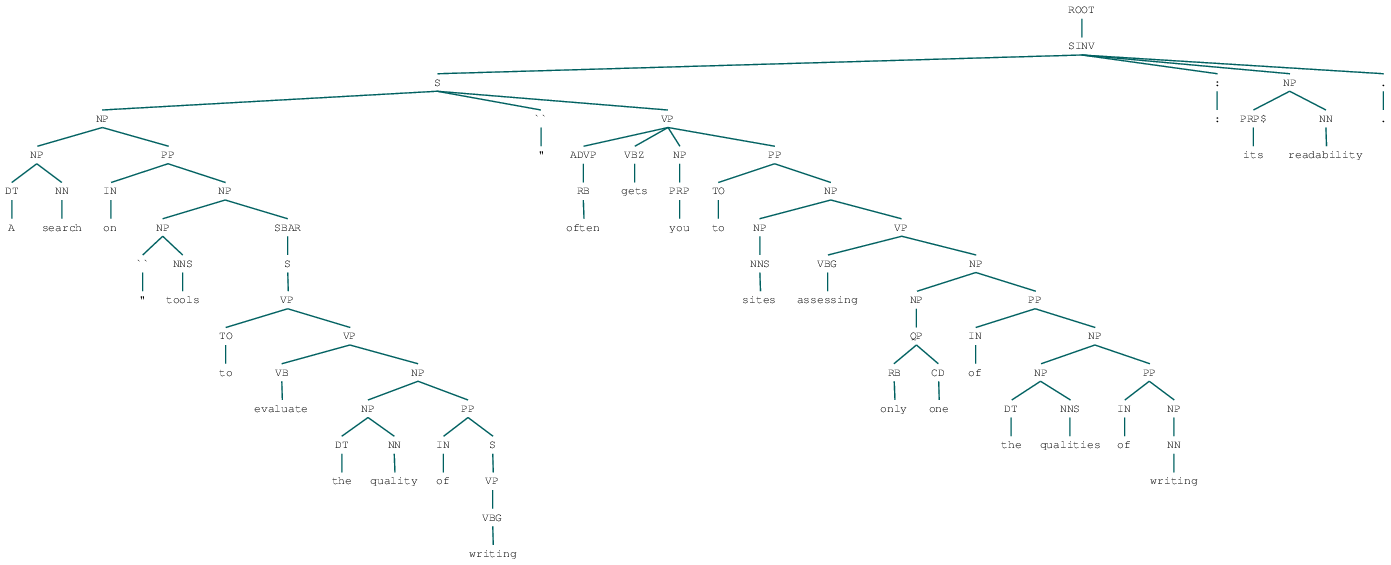

nounsAndVerbDerivedNouns:  [(u'search', u'NN'), (u'tools', u'NNS'), (u'quality', u'NN'), (u'writing', u'VBG'), (u'sites', u'NNS'), (u'assessing', u'VBG'), (u'qualities', u'NNS'), (u'writing', u'NN'), (u'readability', u'NN')] 

topic_strong_words(main clause subj):  [u'search'] 

strong stress:  [u'writing', u'assessing', u'qualities', u'writing', u'readability'] 

weak stress:  [u'tools', u'quality', u'sites'] 

current sentence:  [(u'A', u'DT'), (u'search', u'NN'), (u'on', u'IN'), (u'"', u'``'), (u'tools', u'NNS'), (u'to', u'TO'), (u'evaluate', u'VB'), (u'the', u'DT'), (u'quality', u'NN'), (u'of', u'IN'), (u'writing', u'VBG'), (u'"', u'``'), (u'often', u'RB'), (u'gets', u'VBZ'), (u'you', u'PRP'), (u'to', u'TO'), (u'sites', u'NNS'), (u'assessing', u'VBG'), (u'only', u'RB'), (u'one', u'CD'), (u'of', u'IN'), (u'the', u'DT'), (u'qualities', u'NNS'), (u'of', u'IN'), (u'writing', u'NN'), (u':', u':'), (u'its', u'PRP$'), (u'readability', u'NN'), (u'.', u'.')] 



KeyboardInterrupt: 

In [34]:
#проверка алгоритма(поиск defaultWordSet для каждого предложения)
state = 0
text = SourceText(paragraphs)
sent_list = []

while state == 0:
    print state
    sent, p = text.nextSent()
    while p != 1:
        sent_list.append(SentInfo(sent, UNKNOWN))
        sent_list[-1].setDefaultWordSet()
        sent, p = text.nextSent()
    state = text.nextPar()

In [41]:
STRONG_TOPIC = 10
WEAK_TOPIC = 11

def BetweenFluidOrInverted(sent_list, offset):
    #check Sn-1
    if sent_list[-2].type != FLUID and sent_list[-2].type != INVERTED_TOPIC_CANDIDATE:
        return False
    #check Sn-2
    if sent_list[-3].type != FLUID and sent_list[-3].type != INVERTED_TOPIC_CANDIDATE:
        return False
    if offset == 3:
        if sent_list[-4].type != FLUID and sent_list[-4].type != INVERTED_TOPIC_CANDIDATE:
            return False
    return True
    
def TopicFound(topic_words, topic_type, sentence, previous_sentence, reached_verb, offset, sent_list):
    if offset == 1:
        if not reached_verb:
            sentence.type = FLUID
        else:
            sentence.type = INVERTED_TOPIC_CANDIDATE
    else:
        if not reached_verb:
            if BetweenFluidOrInverted(sent_list, offset):
                sentence.type = FLUID
            else:
                sentence.type = OUT_OF_SYNC
    if topic_type == WEAK_TOPIC:
        if set(topic_words).issubset(sentence.offset_wordset.topic_strong_words[offset - 1]):
            sentence.offset_wordset.topic_weak_words[offset - 1].extend(topic_words)
    elif topic_type == STRONG_TOPIC:
        sentence.offset_wordset.topic_strong_words[offset - 1].extend(topic_words)
                 
def CheckSentenceMainClauses(sentence, previous_sentence, sent_list):
    offset = sentence.current_offset
    main_clause_subjects = sentence.getMainClauseSubjects()
    prev_sent_wordset = list(previous_sentence.topic_weak_words)
    prev_sent_wordset.extend(previous_sentence.topic_strong_words)
    prev_sent_wordset.extend(previous_sentence.stress_strong_words)
    matched_words = [x for x in main_clause_subjects if x in prev_sent_wordset]
    if matched_words != []:
        TopicFound(matched_words, STRONG_TOPIC, sentence, previous_sentence, False, offset, sent_list)
    #FIX какие именно subjects имеются в виду?
    stress_words = [x for x in main_clause_subjects if x not in matched_words]
    sentence.addStressWords([(x, u"") for x in stress_words], offset)
    
def CheckWholeSentence(sentence, previous_sentence, sent_list):
    offset = sentence.current_offset
    reached_verb = False
    reached_topic_or_main = False
    prev_sent_wordset = list(previous_sentence.topic_weak_words)
    prev_sent_wordset.extend(previous_sentence.topic_strong_words)
    prev_sent_wordset.extend(previous_sentence.stress_strong_words)
    main_clause_words = sentence.getMainClauseWords()
    conj_tags = ["VBD", "VBG", "VBN", "VBP", "VBZ"]
    noun_tags = [u"NN", u"NNP", u"NNS", u"NNPS"]
    
    for word in sentence.sent:
        reached_verb = word[1] in conj_tags or reached_verb
        reached_topic_or_main = word[0] in main_clause_words or reached_topic_or_main
        if not reached_verb:
            matches = word[0] in prev_sent_wordset
            if (matches and word[1] in noun_tags) or (matches and reached_topic_or_main and (word[1] == u"VBG")):
                TopicFound(list(word), WEAK_TOPIC, sentence, previous_sentence, False, offset, sent_list)
            elif (word[1] == u"VBG"):
                sentence.addStressWords([word], offset)
        else:
            if (sentence.offset_wordset.topic_strong_words[offset - 1] != []) or (sentence.offset_wordset.topic_weak_words[offset - 1] != []):
                if word[1] in noun_tags:
                    sentence.addStressWords([word], offset)
            else:
                matches = word[0] in prev_sent_wordset
                if (word[1] in noun_tags) and matches:
                    TopicFound(list(word), WEAK_TOPIC, sentence, previous_sentence, True, offset)
                    reached_topic_or_main = true
                elif (word[1] == u"VBG") and matches:
                    sentence.addStressWords([word], offset)
                    
def CheckSentenceProgression(sentence, previous_sentence, sent_list):
    sentence.current_offset += 1
    CheckSentenceMainClauses(sentence, previous_sentence, sent_list)
    CheckWholeSentence(sentence, previous_sentence, sent_list)
    

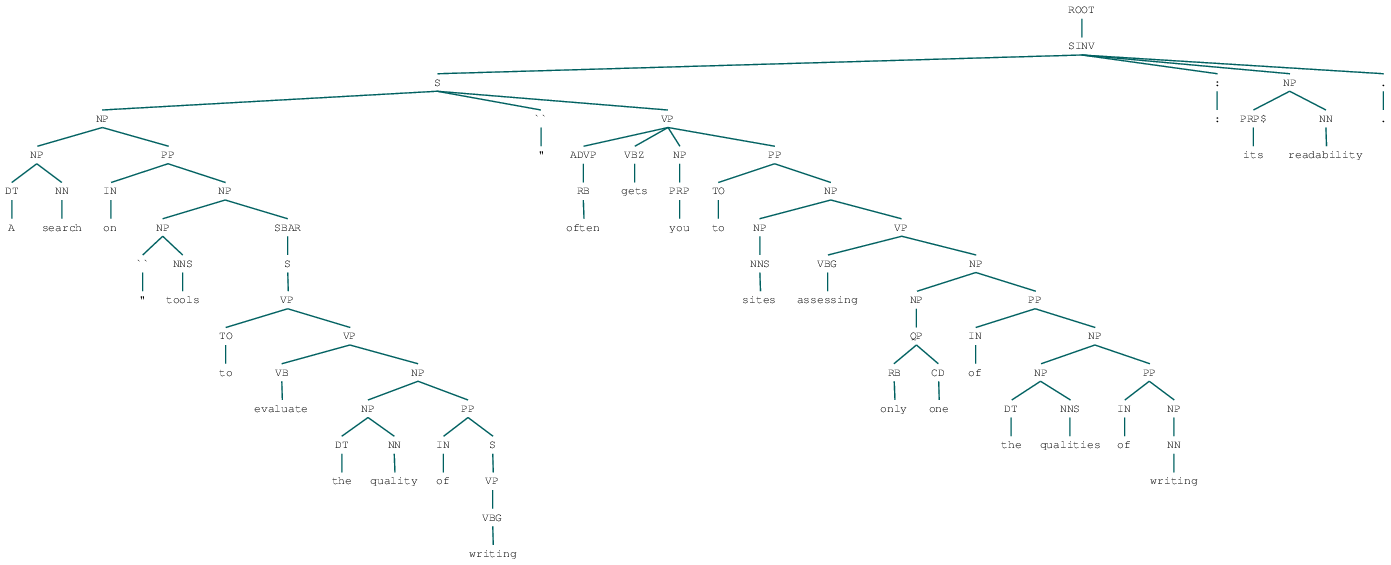

nounsAndVerbDerivedNouns:  [(u'search', u'NN'), (u'tools', u'NNS'), (u'quality', u'NN'), (u'writing', u'VBG'), (u'sites', u'NNS'), (u'assessing', u'VBG'), (u'qualities', u'NNS'), (u'writing', u'NN'), (u'readability', u'NN')] 

topic_strong_words(main clause subj):  [u'search'] 

strong stress:  [u'writing', u'assessing', u'qualities', u'writing', u'readability'] 

weak stress:  [u'tools', u'quality', u'sites'] 

current sentence:  [(u'A', u'DT'), (u'search', u'NN'), (u'on', u'IN'), (u'"', u'``'), (u'tools', u'NNS'), (u'to', u'TO'), (u'evaluate', u'VB'), (u'the', u'DT'), (u'quality', u'NN'), (u'of', u'IN'), (u'writing', u'VBG'), (u'"', u'``'), (u'often', u'RB'), (u'gets', u'VBZ'), (u'you', u'PRP'), (u'to', u'TO'), (u'sites', u'NNS'), (u'assessing', u'VBG'), (u'only', u'RB'), (u'one', u'CD'), (u'of', u'IN'), (u'the', u'DT'), (u'qualities', u'NNS'), (u'of', u'IN'), (u'writing', u'NN'), (u':', u':'), (u'its', u'PRP$'), (u'readability', u'NN'), (u'.', u'.')] 

else
stress_words:
[(u'ease', 

In [42]:
state = 0
text = SourceText(paragraphs)
sent_list = []
sent, p = text.nextSent()
sent_list.append(SentInfo(sent, NOT_APPLICABLE))
sent_list[-1].setDefaultWordSet()
sent, p = text.nextSent()
sent_list.append(SentInfo(sent, UNKNOWN))
if sent_list[-1].beginsWithFluidWords():
    sent_list[-1].type = FLUID
    sent_list[-1].setDefaultWordSet()
else:
    print "else"
    CheckSentenceProgression(sent_list[-1], sent_list[-2], sent_list)
    print sent_list[-1].offset_wordset
    print sent_list[-1].current_offset

In [43]:
print sent_list[-1].offset_wordset.topic_strong_words
print sent_list[-1].offset_wordset.topic_weak_words
print sent_list[-1].offset_wordset.stress_strong_words
print sent_list[-1].offset_wordset.stress_weak_words

[[u'readability'], [], []]
[[], [], []]
[[u'ease', u'formulae', u'indices', u'ease', u'reading', u'writing', u'reading', u'level', u'reader', u'writing', u'formulae', u'readability', u'indices', u'Flesch-Kincaid', u'usefulness'], [], []]
[[], [], []]
